In [1]:
import jax
import jax.numpy as np

from elrpy.dgp import normal_sim_binary
from elrpy.losses import lyapunov_binary_loss, get_wrapped_loss
from elrpy.optim import get_cg_fn, fit, get_clipped_cg_fn
from elrpy.utils import get_dims, get_bootstrap_weights, get_mean_fn, get_mapped_fn
from elrpy.models import init_binary

In [2]:
import pandas as pd
covars = pd.read_csv('../ei/general/data/ar/2016/covars.csv.zip')
results = pd.read_csv('../ei/general/data/ar/2016/pre/results.csv.zip')

groups = set(results.group_id.to_list()).intersection(covars.group_id)
results = results[results.group_id.isin(groups)]
covars = covars[covars.group_id.isin(groups)]

In [3]:
from sklearn.preprocessing import OneHotEncoder
import numpy as onp 

oh_enc = OneHotEncoder().fit(onp.array(list(groups))[:, None])
results_oh = oh_enc.transform(onp.array(results.group_id.to_list())[:, None])
covars_oh = oh_enc.transform(onp.array(covars.group_id.to_list())[:, None])

In [11]:
N = covars_oh.sum(axis=0)
Y = results_oh.T @ (results['y'] / results['n']) * onp.array(N)

In [12]:
from elrpy.data import pd_utils
X, cols, scale = pd_utils.transform_covars(covars)

/Users/njwfish/miniforge3/envs/ei-conf/lib/python3.9/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/njwfish/miniforge3/envs/ei-conf/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [13]:
def get_wrapped_loss(loss_fn, model_fn, axis=None):
    """Wrap loss function to take model parameters and group data.

    Args:
        loss_fn: loss function.
        model_fn: model function.
        num_groups: number of groups.

    Returns:
        function: wrapped loss function.
    """
    def wrapped_loss(model_params, X, Y, G, weights=None):
        """Wrapped loss function.

        Args:
            model_params: model parameters.
            group_X: group covariates.
            group_Y: group outcomes.
            group_N: group number of observations.
            group_weight: group weights.

        Returns:
            float: loss.
        """
        return np.mean(loss_fn(
            model_fn(model_params, X), Y, G, weights=weights
        ), axis=axis)
    
    return wrapped_loss

def lyapunov_binary_loss(p, Y, G, weights=None, eps=1e-6):
    """Lyapunov Central Limit loss for binary outcomes.
    
    Args:
        p (np.ndarray): Array of probabilities of shape (n, k).
        Y (int): Number of successes.
        N (int): Size of group.
    
    Returns:
        float: a normal approximation to the combinatorial log-likelihood.
    """
    mu = G @ p
    phi2 = np.maximum(G @ (p * (1 - p)), eps)
    logp = 1/2 * np.log(phi2) - (1 / phi2) * (Y - mu)**2
    if weights is not None:
        logp = weights * logp
    return -logp


In [14]:
X = np.array(X)
Y = np.array(Y)[:, None]
G = jax.experimental.sparse.BCOO.from_scipy_sparse(covars_oh.T)

In [15]:
model_fn, model_params = init_binary(X)

In [28]:
import jaxopt
wrapped_loss_fn = get_wrapped_loss(lyapunov_binary_loss, model_fn)
solver = jaxopt.BFGS(fun=wrapped_loss_fn, maxiter=3_000)
res = solver.run(model_params, X=X, Y=Y, G=G)

In [29]:
res.state

BfgsState(iter_num=Array(684, dtype=int32, weak_type=True), value=Array(4.400274e+10, dtype=float32), grad=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0.], dtype=float32), stepsize=Array(1., d

In [32]:
solver = jaxopt.BFGS(fun=wrapped_loss_fn, maxiter=3_000)
res = solver.run(model_params, X=X, Y=Y, G=G)

TypeError: __init__() got an unexpected keyword argument 'fun'

In [31]:
res.state

NonlinearCGState(iter_num=Array(3, dtype=int32, weak_type=True), stepsize=Array(1., dtype=float32), error=Array(0., dtype=float32), value=Array(6.032453e+10, dtype=float32), grad=Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [17]:
wrapped_loss_fn = get_wrapped_loss(lyapunov_binary_loss, model_fn)
loss_fn = jax.jit(jax.vmap(get_wrapped_loss(lyapunov_binary_loss, model_fn, axis=0), in_axes=(0, None, None, None, 0)))
loss_and_grad_fn = jax.jit(jax.vmap(jax.value_and_grad(wrapped_loss_fn), in_axes=(0, None, None, None, 0)))
hess_fn = jax.jit(jax.vmap(jax.hessian(wrapped_loss_fn), in_axes=(0, None, None, None, 0)))

In [16]:
wrapped_loss_fn = get_wrapped_loss(lyapunov_binary_loss, model_fn)
loss_fn = jax.jit(jax.vmap(get_wrapped_loss(lyapunov_binary_loss, model_fn, axis=0), in_axes=(0, None, None, None)))
loss_and_grad_fn = jax.jit(jax.vmap(jax.value_and_grad(wrapped_loss_fn), in_axes=(0, None, None, None)))
hess_fn = jax.jit(jax.vmap(jax.hessian(wrapped_loss_fn), in_axes=(0, None, None, None)))

In [22]:
cg_fn = get_clipped_cg_fn(loss_fn, loss_and_grad_fn, hess_fn)

binary_params, gd_norm, history = fit(
    lyapunov_binary_loss, model_fn, model_params[None, :], (X, Y, G),
    verbose=2, lr=1, print_every=1, tol=1e-5,
    maxit=100, mapped_loss_and_dir_fn=cg_fn, keep_history=True
)

(1, 193, 10)
0 	 17.869322 	 563.24615
(1, 193, 10)
1 	 5.1631975 	 118.77209
(1, 193, 10)
2 	 3.5894635 	 5.3507857
(1, 193, 10)
3 	 3.2545702 	 2.79306
(1, 193, 10)
4 	 3.2025018 	 1.8037926
(1, 193, 10)
5 	 3.1954567 	 1.1858988
(1, 193, 10)
6 	 3.1944466 	 0.51233435
(1, 193, 10)
7 	 3.1939878 	 0.4846466
(1, 193, 10)
8 	 3.1937492 	 0.32876042
(1, 193, 10)
9 	 3.193552 	 0.088882245
(1, 193, 10)
10 	 3.1932342 	 0.118918076
(1, 193, 10)
11 	 3.193061 	 0.112434395
(1, 193, 10)
12 	 3.1928506 	 0.14530204
(1, 193, 10)
13 	 3.1927388 	 0.015648907
(1, 193, 10)
14 	 3.1925495 	 0.0028876676
(1, 193, 10)
15 	 3.1924007 	 0.0066073523
(1, 193, 10)
16 	 3.1921425 	 0.0138796335
(1, 193, 10)
17 	 3.1918895 	 0.039007965
(1, 193, 10)
18 	 3.1916533 	 0.079005785
(1, 193, 10)
19 	 3.1914158 	 0.08703412
(1, 193, 10)
20 	 3.191215 	 0.029352698
(1, 193, 10)
21 	 3.1910188 	 0.030908532
(1, 193, 10)
22 	 3.1908286 	 0.029165355
(1, 193, 10)
23 	 3.1907 	 0.003326899
(1, 193, 10)
24 	 3.19048

In [7]:
W = get_bootstrap_weights(rng, G, 300)

In [8]:
cg_fn = get_cg_fn(loss_and_grad_fn, hess_fn)

binary_params, gd_norm, history = fit(
    lyapunov_binary_loss, model_fn, np.tile(model_params[None, :], (300, 1)), (X, Y, G), group_weights=W[..., None],
    verbose=2, lr=1, print_every=1, tol=5e-5,
    maxit=100, mapped_loss_and_dir_fn=cg_fn, keep_history=True
)

2023-11-27 18:45:39.399155: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  slice.104 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2023-11-27 18:45:41.025261: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.627916s
Constant folding an instruction is taking > 1s:

  slice.104 (displaying the full instruction incurs a runtime overhead. Raise your logging level to 4 or above).

This isn't necessarily a bug; constant-folding is inherently a trade-off betwe

0 	 1269.4014 	 2145.8992
1 	 388.3105 	 700.20197


KeyboardInterrupt: 

In [27]:
binary_params

Array([[-0.8762771 , -0.34314072,  0.4048502 , ..., -0.10029334,
        -0.10149337,  0.3017273 ],
       [-0.8762771 , -0.34314072,  0.4048502 , ..., -0.10029337,
        -0.10149337,  0.3017273 ],
       [-0.8762771 , -0.34314072,  0.4048502 , ..., -0.10029337,
        -0.10149337,  0.3017273 ],
       ...,
       [-0.8762771 , -0.3431407 ,  0.40485024, ..., -0.10029334,
        -0.10149338,  0.3017273 ],
       [-0.8762771 , -0.34314072,  0.40485018, ..., -0.10029334,
        -0.10149337,  0.3017273 ],
       [-0.8762771 , -0.3431407 ,  0.40485024, ..., -0.10029334,
        -0.10149338,  0.3017273 ]], dtype=float32)

In [7]:
cg_fn = get_cg_fn(mapped_loss_and_grad_fn, mapped_hess_fn)

boot_params, gd_norm, history = gd(
    lyapunov_binary_loss, model_fn, np.tile(binary_params, (1_000, 1)), group_data, group_weights=w[..., None],
    verbose=2, lr=1, print_every=1, tol=1e-4,
    maxit=100, mapped_loss_and_dir_fn=cg_fn, keep_history=True
)

0 	 -1.3092031 	 3.8715534
1 	 -1.3217705 	 0.026025068
2 	 -1.321771 	 5.8652247e-05
Converged!
2 -1.321771 5.8652247e-05


In [8]:
np.percentile(boot_params, 97.5, axis=0), np.mean(boot_params, axis=0), np.percentile(boot_params, 2.5, axis=0)

(Array([-0.86597353, -0.3356535 ,  0.4129642 , -0.6760616 ,  0.63289416,
         0.01118292,  0.79537773, -0.09305118, -0.09374186,  0.3101299 ],      dtype=float32),
 Array([-0.87597793, -0.34300178,  0.40539646, -0.68573797,  0.6244735 ,
         0.00345865,  0.78631145, -0.10019332, -0.10153584,  0.30175263],      dtype=float32),
 Array([-0.88645166, -0.35060707,  0.3983707 , -0.69541305,  0.61590546,
        -0.00455674,  0.77769244, -0.10778944, -0.10931624,  0.29322946],      dtype=float32))

In [68]:
# plot loss landscape
import matplotlib.pyplot as plt
# get meshgrid
t = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(t, t)
min_eighs = []
losses = []
for (x, y) in zip(X.flatten(), Y.flatten()):
    min_eighs.append(np.linalg.eigh(mapped_hess_fn(np.array([x, y]), (*group_data, w1)))[0][0])
    losses.append(mapped_loss_and_grad_fn(np.array([x, y]), (*group_data, w1))[0])


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (None, 1).

In [33]:
traj = np.array([h[0] for h in history])
traj = np.vstack([np.zeros(2), traj])

Text(0.5, 1.0, 'Minimum eigenvalue of Hessian for 2D binary model')

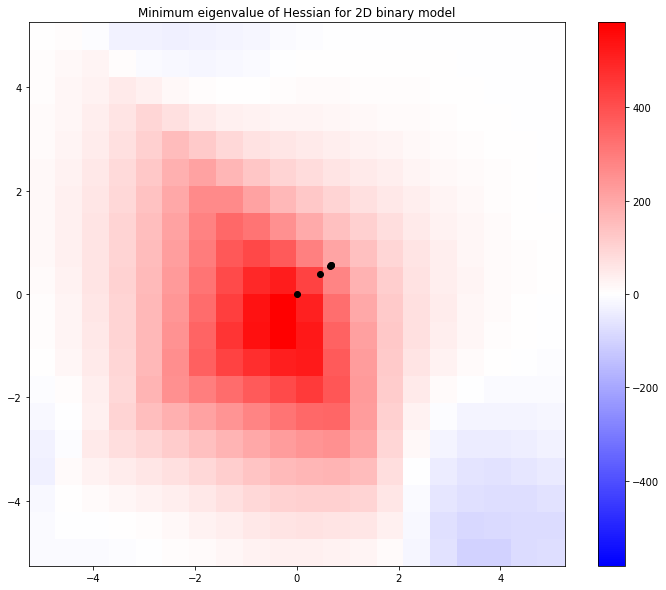

In [34]:
import matplotlib.colors as colors
Z = np.array(min_eighs).reshape(X.shape)
norm = colors.TwoSlopeNorm(vmin=-Z.max(), vcenter=0, vmax=Z.max())

plt.figure(figsize=(12,10))

plt.pcolor(X, Y, Z, norm=norm, cmap="bwr") 
plt.plot(traj[:, 0], traj[:, 1], 'o', color="black")
# plt.plot(binary_params[0], binary_params[1], 'o', color='black') 
# plt.contourf(X, Y, Z, 15, norm=norm) 
plt.colorbar()
plt.title("Minimum eigenvalue of Hessian for 2D binary model")

Text(0.5, 1.0, 'Loss landscape for 2D binary model')

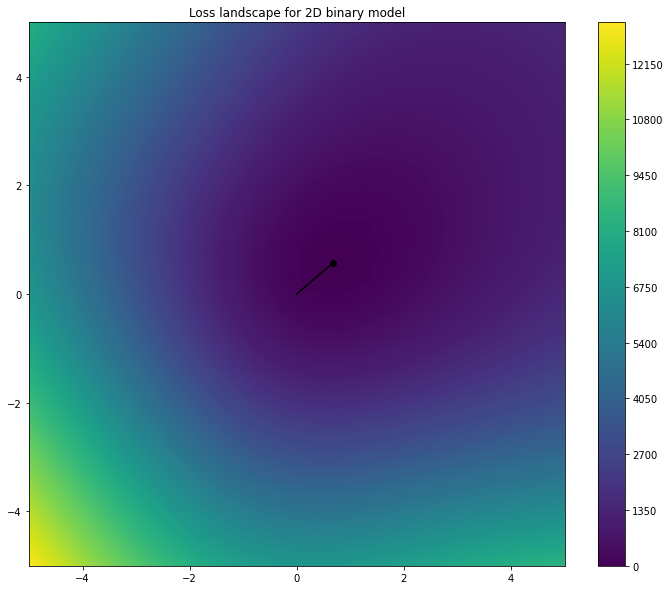

In [35]:
plt.figure(figsize=(12,10))
plt.contourf(X, Y, np.array(losses).reshape(X.shape), 300, cmap='viridis')
plt.plot([0, binary_params[0]], [0, binary_params[1]], color="black")
plt.plot(binary_params[0], binary_params[1], 'o', color='black') 
plt.colorbar()
plt.title("Loss landscape for 2D binary model")

In [7]:
import jax
import jax.numpy as np
from elrpy.models import binary_model

@jax.jit
def hess_exp_lyapunov_binary_loss(params, true_params, x):
    p = binary_model(params, x)
    phi2 = np.sum(p * (1 - p))
    mu = np.sum(p)
    

    p_star = binary_model(true_params, x)
    mu_star = np.sum(p_star)
    phi2_star = np.sum(p_star * (1 - p_star))
    # print(mu_star / x.shape[0], (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2), (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), -(mu_star - mu)/phi2, phi2_star/phi2, (mu_star - mu)**2/phi2, 1/2 * (mu_star - mu)**2/phi2**2, (mu_star - mu)/phi2)
    outer_x = np.einsum('...c,...d->...cd', x, x)
    phi2x = np.sum((p * (1 - p))[:, None] * x, axis=0)
    dphi2x = np.sum((p * (1 - p) * (1 - 2 * p))[:, None] * x, axis=0)
    dphi2xx = np.sum((p * (1 - p) * (1 - 2 * p))[:, None, None] * outer_x, axis=0)
    ddphi2xx = np.sum((p * (1 - p) * (1 + 6 * p * (p - 1)))[:, None, None] * outer_x, axis=0)
    
    t1 = 1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2) * ddphi2xx
    t2 = -(mu_star - mu)/phi2 * dphi2xx
    t3 = (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2) / phi2**2 * np.outer(dphi2x, dphi2x)
    t4 = 1 / phi2 * np.outer(phi2x, phi2x)
    
    hess = t1 + t2 + t3 + t4
    return 2 * hess, (t1, t2, t3, t4),  1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), (mu_star - mu)/phi2

In [8]:
@jax.jit
def hess_t_lyapunov_binary_loss(t, true_params, x):
    params = t * true_params
    p = binary_model(params, x)
    phi2 = np.sum(p * (1 - p))
    mu = np.sum(p)
    
    p_star = binary_model(true_params, x)
    mu_star = np.sum(p_star)
    phi2_star = np.sum(p_star * (1 - p_star))

    x = (x @ params).T
    # print(mu_star / x.shape[0], (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2), (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), -(mu_star - mu)/phi2, phi2_star/phi2, (mu_star - mu)**2/phi2, 1/2 * (mu_star - mu)**2/phi2**2, (mu_star - mu)/phi2)
    outer_x = jax.vmap(np.dot)(x, x)
    phi2x = np.sum((p * (1 - p)) * x, axis=0)
    dphi2x = np.sum((p * (1 - p) * (1 - 2 * p)) * x, axis=0)
    dphi2xx = np.sum((p * (1 - p) * (1 - 2 * p)) * outer_x, axis=0)
    ddphi2xx = np.sum((p * (1 - p) * (1 + 6 * p * (p - 1))) * outer_x, axis=0)
    
    t1 = 1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2) * ddphi2xx
    t2 = -(mu_star - mu)/phi2 * dphi2xx
    t3 = (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2) / phi2**2 * np.dot(dphi2x, dphi2x)
    t4 = 1 / phi2 * np.dot(phi2x, phi2x)
    
    hess = t1 + t2 + t3 + t4
    return 2 * hess, (t1, t2, t3, t4),  1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), (mu_star - mu)/phi2

In [72]:
group_data[0][1].shape

(1664, 2)

In [66]:

for k in range(len(group_data[0])):
    H1, t, c1, d = hess_t_lyapunov_binary_loss(0, beta.flatten(), group_data[0][k])
    rng = jax.random.PRNGKey(k + 3)
    t = jax.random.uniform(rng)
    H, tt, c, d = hess_t_lyapunov_binary_loss(t, beta.flatten(), group_data[0][k])
    print(k, t, H1, H)

0 0.8653928 0.0 0.44589376
1 0.16215026 0.0 5.167947
2 0.6343405 0.0 2445.0427
3 0.51601326 0.0 5.756989
4 0.8441069 0.0 51.689354
5 0.9119096 0.0 103.78547
6 0.65711427 0.0 99.41739
7 0.08938682 0.0 10.154454
8 0.45246768 0.0 0.23940206
9 0.3037703 0.0 0.049302332
10 0.8186326 0.0 0.666452
11 0.22146237 0.0 3.042394
12 0.5277747 0.0 23.454403
13 0.55171585 0.0 273.4535
14 0.32842708 0.0 2.2261012
15 0.9378201 0.0 14.493642
16 0.744781 0.0 43.195858
17 0.22824931 0.0 30.833637
18 0.54728234 0.0 4.7123
19 0.9258436 0.0 9.599702
20 0.60175097 0.0 34.551525
21 0.12127352 0.0 0.3685405
22 0.37329996 0.0 170.65652
23 0.37956572 0.0 60.92818
24 0.026275992 0.0 7.043793e-05
25 0.39540493 0.0 819.3443
26 0.5139717 0.0 6.1677556
27 0.92384136 0.0 46.07413
28 0.7877443 0.0 25.033339
29 0.7519332 0.0 0.35792542
30 0.79524577 0.0 3.8019414
31 0.7453269 0.0 91.442505
32 0.33526587 0.0 0.007994495
33 0.27806175 0.0 39.234493
34 0.2462827 0.0 4.6576867
35 0.9958941 0.0 2.259924
36 0.49880707 0.0 2.05

In [356]:
import jax
import jax.numpy as np
from elrpy.models import binary_model

# @jax.jit
def hess_exp_lyapunov_binary_loss(params, true_params, x):
    p = binary_model(params, x)
    phi2 = np.sum(p * (1 - p))
    mu = np.sum(p)
    

    p_star = binary_model(true_params, x)
    mu_star = np.sum(p_star)
    phi2_star = np.sum(p_star * (1 - p_star))
    outer_x = np.einsum('...c,...d->...cd', x, x)
    phi2x = np.sum((p * (1 - p))[:, None] * x, axis=0)
    dphi2x = np.sum((p * (1 - p) * (1 - 2 * p))[:, None] * x, axis=0)
    dphi2xx = np.sum((p * (1 - p) * (1 - 2 * p))[:, None, None] * outer_x, axis=0)
    ddphi2xx = np.sum((p * (1 - p) * (1 + 6 * p * (p - 1)))[:, None, None] * outer_x, axis=0)

    print(np.linalg.eigh(ddphi2xx)[0], (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2))
    
    t1 = 1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2) * ddphi2xx
    t2 = -(mu_star - mu)/phi2 * dphi2xx
    t3 = (phi2_star/phi2 + (mu_star - mu)**2/phi2 - 1 / 2) / phi2**2 * np.outer(dphi2x, dphi2x)
    t4 = 1 / phi2 * np.outer(phi2x, phi2x)
    
    
    hess = t1 + t2 + t3 + t4
    return 2 * hess, (t1, t2, t3, t4),  1 / (2 * phi2) * (1 - phi2_star/phi2 - (mu_star - mu)**2/phi2), (mu_star - mu)/phi2

In [357]:
t = hess_exp_lyapunov_binary_loss(0.1 * beta.flatten(), beta.flatten(), group_data[0][10])[1]

[-105.01039   -28.52099   -27.590672  -23.940548  -23.102432  -21.498821
  -20.402363  -20.161726  -16.978083  -14.751165] -58.05064 58.55064


In [268]:
1 / (group_data[0][k].shape[0] / 4)

0.035398230088495575

In [253]:
np.linalg.eigh(t[3])

(Array([-6.6883564e-07, -3.7897973e-07, -9.9420383e-08, -5.8985815e-08,
        -3.7097745e-09,  5.1422515e-09,  1.2703302e-07,  2.7303113e-07,
         1.1207234e-06,  3.3735134e+01], dtype=float32),
 Array([[ 1.42447874e-01, -6.19293928e-01, -4.65404481e-01,
         -4.00122046e-01,  1.01541169e-01, -4.84616011e-02,
         -5.46195172e-02,  1.63150057e-01,  4.03289855e-01,
          1.20752558e-01],
        [-3.71568233e-01,  3.03750098e-01, -2.96154656e-02,
         -1.07412525e-02, -3.08179297e-04,  2.56513357e-02,
         -8.88244882e-02, -4.55806777e-03,  7.01024473e-01,
         -5.18340051e-01],
        [ 3.63032401e-01,  4.17383403e-01,  1.77417576e-01,
         -5.33726037e-01,  8.78660008e-02, -3.55825014e-02,
          4.08499926e-01, -2.72121549e-01,  2.50632346e-01,
          2.54818529e-01],
        [-1.07569352e-01,  2.63949960e-01,  4.37895767e-02,
         -1.34868035e-02,  7.22955689e-02,  1.42085515e-02,
          1.84720531e-01,  8.99538577e-01,  4.84003574e-02

In [250]:
np.linalg.eigh(hess_exp_lyapunov_binary_loss(0.5 * beta.flatten(), beta.flatten(), group_data[0][k])[0])[0]

-0.70055306


Array([-0.11612222,  0.2271569 ,  0.48492092,  0.68342495,  0.7507059 ,
        0.7750699 ,  0.9355562 ,  1.002058  ,  1.2901878 , 70.381905  ],      dtype=float32)

In [226]:
(binary_model(beta.flatten(), group_data[0][k]) * (1 - binary_model(beta.flatten(), group_data[0][k]))).mean()

Array(0.18954492, dtype=float32)

In [228]:
(binary_model(beta.flatten(), group_data[0][k])).mean() * (1 - (binary_model(beta.flatten(), group_data[0][k])).mean())

Array(0.23862244, dtype=float32)

In [229]:
(binary_model(beta.flatten(), group_data[0][k])).mean()

Array(0.6066656, dtype=float32)

In [235]:
binary_model(beta.flatten(), group_data[0][k])

Array([0.5322552 , 0.71743584, 0.8440471 , 0.69025177, 0.86172175,
       0.92059845, 0.6529735 , 0.85587466, 0.44015113, 0.6972561 ,
       0.49392554, 0.54733324, 0.723354  , 0.6300325 , 0.91910267,
       0.599916  , 0.82093287, 0.70531505, 0.3291549 , 0.60666305,
       0.5962202 , 0.47623867, 0.96397877, 0.4828992 , 0.7665035 ,
       0.91347945, 0.486745  , 0.37603146, 0.46989706, 0.70501274,
       0.59922796, 0.17969178, 0.9615677 , 0.4463793 , 0.3818087 ,
       0.6415459 , 0.7709335 , 0.2870071 , 0.45871362, 0.8373599 ,
       0.7718902 , 0.55211943, 0.67444605, 0.58503544, 0.84869903,
       0.06722485, 0.13647027, 0.64404   , 0.61032516, 0.7544116 ,
       0.6239271 , 0.4644104 , 0.434181  , 0.67191213, 0.5214437 ,
       0.9748038 , 0.9647365 , 0.71103394, 0.7727409 , 0.29957807,
       0.686108  , 0.2882642 , 0.47191706, 0.18209156, 0.4838587 ,
       0.5738535 , 0.9434367 , 0.6240802 , 0.2989089 , 0.7555742 ,
       0.86754847, 0.52892554, 0.96130115, 0.676197  , 0.37405

In [220]:
k = 268
rng = jax.random.PRNGKey(k + 2)
t = jax.random.uniform(rng)

In [219]:

for k in range(len(group_data[0])):
    # H1, t, c1, d = hess_exp_lyapunov_binary_loss(0 * beta.flatten(), beta.flatten(), group_data[0][k])
    rng = jax.random.PRNGKey(k + 2)
    t = jax.random.uniform(rng)
    H, tt, c, d = hess_exp_lyapunov_binary_loss(t * beta.flatten(), beta.flatten(), group_data[0][k])
    print(k, t, binary_model(beta.flatten(), group_data[0][k]).mean(), np.linalg.eigh(H)[0])

0 0.4240216 0.38579786 [   4.145019     5.844952     6.4646573    6.546616     7.364783
    8.726075     9.621903     9.88111     10.110066  1311.0406   ]
1 0.8653928 0.41334665 [-2.95558628e-02  1.15390666e-01  1.34282336e-01  1.37348071e-01
  1.98832795e-01  2.19564706e-01  2.50059754e-01  3.06418538e-01
  4.08007681e-01  1.42460022e+02]
2 0.16215026 0.4114868 [   8.928448    9.373969   10.271558   10.591008   11.306983   12.791623
   13.888302   14.261965   15.0259   3155.1619  ]
3 0.6343405 0.26365554 [  7.943977  11.269225  13.202663  14.488474  15.219895  16.218792
  17.289703  19.047863  21.473368 981.5915  ]
4 0.51601326 0.14092675 [ 1865.5404  1959.4548  2085.1272  2158.4062  2183.6006  2249.4763
  2314.7683  2342.016   2447.9482 53930.184 ]
5 0.8441069 0.30870286 [  1.2155668   1.7894235   1.9152874   2.0313973   2.160241    2.5227706
   2.7562096   3.2339017   3.5637808 366.27426  ]
6 0.9119096 0.53934896 [-1.1595631e-02  2.5056545e-02  6.3855901e-02  7.4193247e-02
  1.05488

In [163]:
n = 100
H = jax.hessian(lambda x, y: lyapunov_binary_loss(sigmoid(x), y, y))(np.ones(n) * 1/ 2, 0.75 * n)

In [331]:
np.linalg.eigh(t[0])

(Array([-0.00059489,  0.00112573,  0.00171103,  0.00185994,  0.00244545,
         0.00263842,  0.00360414,  0.00418008,  0.00471196,  0.01049092],      dtype=float32),
 Array([[-0.43736583, -0.61813766,  0.06984194, -0.37308535,  0.23060748,
          0.03619352, -0.2920438 , -0.2159922 , -0.29928347,  0.08089706],
        [-0.15833649,  0.34297872,  0.28886408, -0.0161324 ,  0.48196712,
         -0.14468724, -0.1480574 ,  0.13414343,  0.19208393,  0.66599864],
        [ 0.14454944,  0.06879359, -0.5867334 ,  0.18590851,  0.4386176 ,
         -0.32643905, -0.4331654 , -0.22946444,  0.10760536, -0.2115233 ],
        [-0.4241231 , -0.23687679,  0.02104214,  0.3603713 ,  0.15748222,
          0.2727025 ,  0.21383236, -0.13736926,  0.66855145, -0.15157871],
        [ 0.44726452, -0.32035536,  0.22872183,  0.5356779 ,  0.0816997 ,
          0.05793631,  0.08726203, -0.44386876, -0.21740596,  0.31005126],
        [ 0.07313117, -0.28525826, -0.29340038, -0.05731076,  0.39454895,
         -0.2

In [164]:
np.linalg.eigh(H)

(Array([0.0929051 , 0.09290527, 0.09290531, 0.09290534, 0.09290535,
        0.09290536, 0.09290537, 0.09290538, 0.09290539, 0.09290539,
        0.0929054 , 0.09290541, 0.09290541, 0.09290541, 0.09290542,
        0.09290543, 0.09290544, 0.09290544, 0.09290544, 0.09290544,
        0.09290544, 0.09290545, 0.09290545, 0.09290545, 0.09290545,
        0.09290545, 0.09290545, 0.09290545, 0.09290545, 0.09290546,
        0.09290546, 0.09290546, 0.09290546, 0.09290546, 0.09290546,
        0.09290546, 0.09290547, 0.09290547, 0.09290547, 0.09290547,
        0.09290547, 0.09290547, 0.09290548, 0.09290548, 0.09290548,
        0.09290548, 0.09290548, 0.09290548, 0.09290548, 0.09290548,
        0.09290548, 0.09290548, 0.09290548, 0.09290548, 0.09290548,
        0.09290549, 0.09290549, 0.09290549, 0.0929055 , 0.0929055 ,
        0.0929055 , 0.09290551, 0.09290551, 0.09290551, 0.09290551,
        0.09290551, 0.09290551, 0.09290551, 0.09290551, 0.09290551,
        0.09290551, 0.09290552, 0.09290552, 0.09

In [165]:
np.diag(H) - np.sum(H - np.diag(np.diag(H)), axis=0)

Array([-0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 ,
       -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 ,
       -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 , -0.2536845 ,
       -0.2536845 , -0.2536845 , -0.2536845 , -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25368446,
       -0.25368446, -0.25368446, -0.25368446, -0.25368446, -0.25

In [92]:
from jax.scipy.special import expit as sigmoid

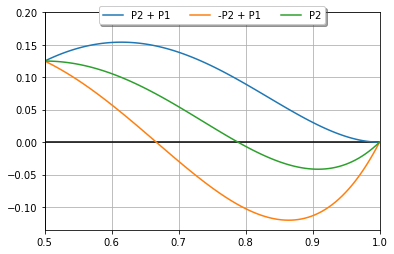

In [389]:
import matplotlib.pyplot as plt

p = np.linspace(0.5, 1, 100)
plt.axhline(y=0., color='black', linestyle='-')
plt.axvline(x=0.5, color='black', linestyle='-')
# plt.plot(p, -p * (1 - p) * (1 - 2 * p), label="P2")
# plt.plot(p, p * (1 - p) * (1 - 2 * p), label="P2")
# plt.plot(p, -p * (1 - p) * (1 + 6 * p * (p - 1)), label="p (1 - p) (1 - 6p (p - 1))")
plt.plot(p, np.abs(p * (1 - p) * (1 - 2 * p)) - p * (1 - p) * (1 + 6 * p * (p - 1)), label="P2 + P1")
plt.plot(p, -np.abs(p * (1 - p) * (1 - 2 * p)) - p * (1 - p) * (1 + 6 * p * (p - 1)), label="-P2 + P1")
plt.plot(p, - p * (1 - p) * (1 + 6 * p * (p - 1)), label="P2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim([0.5, 1])
plt.ylim([-0.135, 0.2])
plt.grid('on')

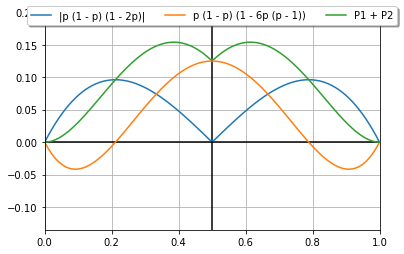

In [376]:
import matplotlib.pyplot as plt

p = np.linspace(0, 1, 100)
plt.axhline(y=0., color='black', linestyle='-')
plt.axvline(x=0.5, color='black', linestyle='-')
plt.plot(p, np.abs(p * (1 - p) * (1 - 2 * p)), label="|p (1 - p) (1 - 2p)|")
plt.plot(p, -p * (1 - p) * (1 + 6 * p * (p - 1)), label="p (1 - p) (1 - 6p (p - 1))")
plt.plot(p, np.abs(p * (1 - p) * (1 - 2 * p)) - p * (1 - p) * (1 + 6 * p * (p - 1)), label="P1 + P2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim([0, 1])
plt.ylim([-0.135, 0.2])
plt.grid('on')

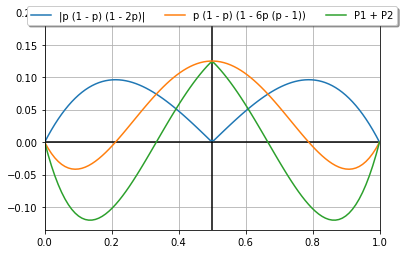

In [378]:
import matplotlib.pyplot as plt

p = np.linspace(0, 1, 100)
plt.axhline(y=0., color='black', linestyle='-')
plt.axvline(x=0.5, color='black', linestyle='-')
plt.plot(p, np.abs(p * (1 - p) * (1 - 2 * p)), label="|p (1 - p) (1 - 2p)|")
plt.plot(p, -p * (1 - p) * (1 + 6 * p * (p - 1)), label="p (1 - p) (1 - 6p (p - 1))")
plt.plot(p, -np.abs(p * (1 - p) * (1 - 2 * p)) - p * (1 - p) * (1 + 6 * p * (p - 1)), label="P1 + P2")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim([0, 1])
plt.ylim([-0.135, 0.2])
plt.grid('on')

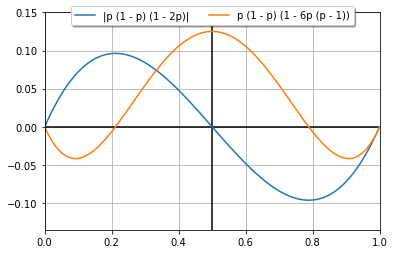

In [390]:
import matplotlib.pyplot as plt

p = np.linspace(0, 1, 100)
plt.axhline(y=0., color='black', linestyle='-')
plt.axvline(x=0.5, color='black', linestyle='-')
plt.plot(p, (p * (1 - p) * (1 - 2 * p)), label="|p (1 - p) (1 - 2p)|")
plt.plot(p, -p * (1 - p) * (1 - 6 * p + 6 * p**2), label="p (1 - p) (1 - 6p (p - 1))")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fancybox=True, shadow=True)
plt.xlim([0, 1])
plt.ylim([-0.135, 0.15])
plt.ylim([-0.135, 0.15])
plt.grid('on')